# Introduction to Relational Databases with Python

**La Serena School for Data Science: Applied Tools for Data-driven Science**, 

La Serena, August 2023.

Mauro San Martín, 
`msmartin@userena.cl`

This notebook is provided as supplementary material for the course **Introduction to Relational Databases** at the **La Serena School for Data Science: Applied Tools for Data-driven Science**, and its purpose is to support the work during the hands-on sesion (last part of the course).

This notebook is organized as follows:

1. *Preliminaries*. 
    What do you need to do before start to work with this notebook.
    
1. *Creating a Database*. 
    Implementing a schema for the weather database. 
    
1. *Loading data into the database*. 
    Loading the data from csv files into the database.
    
1.  *Querying the database*.
    Examples of queries over the weather database.


In [2]:
%%html
<style>
    .alert{
        background-color: #FFFF00;
        font-weight: bold;
    }
    .warning{
        background-color: #F95000;
        font-weight: bold;
    }
</style>

**WARNING**

<div class="warning">

There are two versions of this notebook: 
    one to work with an actual RDBMS using `psycopg`, that version requires access to an RDBMS running PostgreSQL, and 
    one to work with a local file and `sqlite` (a library that allows to use a local file as it were a database in an RDBMS).</div>
  
<div class="alert">
  
**This notebook is intended to work with a `PostgreSQL` server**    

</div>

# Preliminaries

## Software Environment

To execute the code in this notebook you need access to an appropriate software environment, which should include:

- Base software: `python`, `ipython`, and `jupyter-notebooks` (If your computer did not have them before the school, you probably already install them in a previous course of the school). For the optional activities you will also need `matplotlib`.

- `psycopg2`:programming library that implements a connector to a PostgreSQL RDBMS (ww.postgresql.org)

Also you need tha data in the acompaining files: `stations.csv`, `sensors.csv`, `lsc.csv`, `cgr.csv`, and `rmr.csv` (these five files should be available in the `data` subfolder along with this notebook).


## Test Database

In this notebook we will work with data from the [Ceazamet](www.ceazamet.cl), Centro de Estudios Avanzados en Zonas Áridas(ULS-UCN-INIA).
The test database will be populated with measures from sensors installed in three Ceazamet's weather stations, recorded during five years. 

From this site we downloaded five years of daily data (min, avg, and max) for selected sensors of three weather stations nearby La Serena, each station has a different array of sensors. You can information on each weather station [here](https://www.ceazamet.cl/index.php?pag=mod_estacion&e_cod=LSC&p_cod=ceazamet), and a REST web service to download data [here](https://www.ceazamet.cl/ws/pop_ws_doc.php). 

Data is available in five `.csv` files (see `data` subfolder):
- `stations.csv`: stations data.
- `sensors.csv`: data of sensors available in each station.
- `lsc.csv`: five years of daily measures (min, avg, and max) for selected sensors of La Serena - CEAZA station.
- `cgr.csv`: five years of daily measures (min, avg, and max) for selected sensors of La Serena - Cerro Grande station.
- `rmr.csv`: five years of daily measures (min, avg, and max) for selected sensors of La Serena - Romeral station.


# Creating the database

In this section you will create a relational database to store tha data provided, following these steps:
1. Schema definition
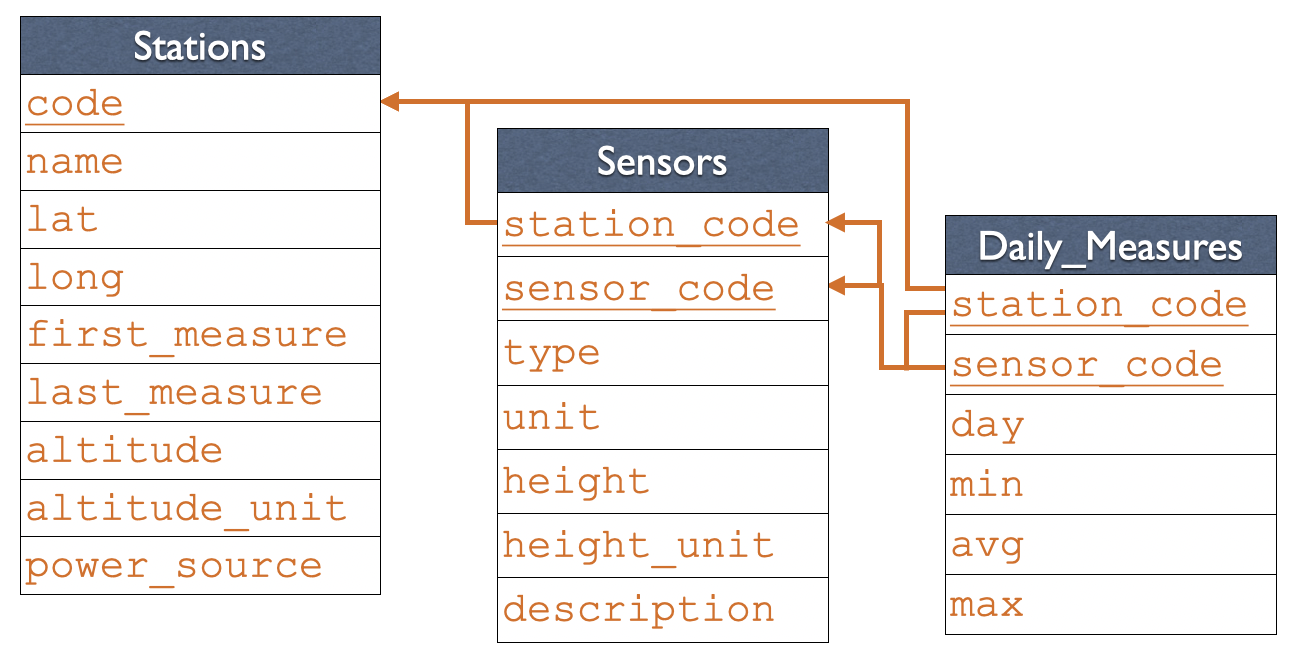

1. Data loading from csv files into the database.

# 1. Schema definition

In [1]:
import pandas as pd
import re

#Base path for data files
#Local environment: files in  `data` subfolder along with the notebook
#base_path = "data/"
#colab environment: files in  `data` subfolder in the storage space of the notebook, this may vary, check the path of your files (context menu of each file)
base_path = "./data/"

In [4]:
import psycopg2

con = psycopg2.connect(
	host='192.168.0.100', database='betelgeuse_2', 
	user='betelgeuse', password='esueglet')

cur = con.cursor()


In [ ]:
#Delete tables (execute only if you want to start over)
cur.execute('drop table if exists daily_measures')
cur.execute('drop table if exists sensors')
cur.execute('drop table if exists stations')


In [10]:
#Create tables
create_stations = '''create table if not exists stations(
                                                     code text primary key,
                                                     name text,
                                                     lat  text,
                                                     long text,
                                                     first_measure timestamp,
                                                     last_measure  timestamp,
                                                     altitude numeric,
                                                     altitude_unit text,
                                                     power_source text)'''
cur.execute(create_stations)

In [11]:


create_sensors = '''create table if not exists sensors(
                                                     station_code text,
                                                     sensor_code  text,
                                                     type         text,
                                                     unit         text,
                                                     height       numeric,
                                                     height_unit  text,
                                                     description text, 
                                                     primary key(station_code, sensor_code),
                                                     foreign key(station_code) references stations(code))'''
cur.execute(create_sensors)


In [12]:

create_measures = '''create table if not exists daily_measures(
                                                     station_code text,
                                                     sensor_code  text,
                                                     day          date,
                                                     min          numeric,
                                                     avg          numeric,
                                                     max          numeric,
                                                     primary key(station_code, sensor_code, day),
                                                     foreign key(station_code) references stations(code),
                                                     foreign key(station_code, sensor_code) references sensors(station_code, sensor_code))'''
cur.execute(create_measures)
con.commit()

In [13]:
#Check table creation
cur.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")

for table in cur.fetchall():
    print(table)

('stations',)
('sensors',)
('daily_measures',)


## 2. Loading data into the database

In [14]:
# Base de datos que tenemos en CSV y queremos insertar
weather_stations = pd.read_csv(base_path+'weather stations.csv',sep=';') 

# Postgress Query, where we replace the data in %s
insert_stations = 'insert into stations values (%s,%s,%s,%s,%s,%s,%s,%s,%s)'

# Explora el pandas y consigue los datos
# uno a uno los agrega
for i in range(len(weather_stations)):
    code  = weather_stations.iloc[i]['code']
    name  = weather_stations.iloc[i]['name']
    lat   = weather_stations.iloc[i]['lat']
    long  = weather_stations.iloc[i]['long']
    first = weather_stations.iloc[i]['first measure timestamp']
    last  = weather_stations.iloc[i]['last measure timestamp']
    #note that we split de altitude column in two (magnitude and unit), before inserting in the table
    altitude_lst = re.findall(r"[\w']+",weather_stations.iloc[i]['altitude']) 
    altitude = altitude_lst[0]
    altitude_unit = altitude_lst[1]
    power_source = weather_stations.iloc[i]['power source']


    #The query with the values are sent to the database
    cur.execute(insert_stations, (code, name, lat, long, first, last, altitude, altitude_unit, power_source))

# Commit a la Base de datos
con.commit()

In [ ]:
result = cur.execute("select * from stations")
result

In [16]:
result = cur.execute("select * from stations")
for row in result:
   print(row)

TypeError: 'NoneType' object is not iterable

In [15]:
#Check insertion
#result = cur.execute("select * from stations")
#for row in result:
#    print(row)

stations = pd.read_sql_query("SELECT * FROM stations", con)
stations

,code,name,lat,long,first_measure,last_measure,altitude,altitude_unit,power_source
0,LSC,La Serena [CEAZA],-29.915.015,-71.242.214,2014-07-18 12:45:00,2021-08-01 12:45:00,90.0,msnm,"solar panel, 30w"
1,CGR,La Serena [Cerro Grande],-29.938.475,-71.223.505,2015-08-05 15:05:00,2021-05-26 13:25:00,513.0,msnm,"solar panel, 30w"
2,RMR,La Serena [El Romeral],-29.754.064,-71.257.442,2004-02-01 00:03:00,2021-08-01 08:00:00,162.0,msnm,"solar panel, 30w"


In [17]:
# Insert sensors data 
sensors = pd.read_csv(base_path+'sensors.csv',sep=';')  
#insert query string, question marks will be replaced by actual values on submission
insert_sensors = 'insert into sensors values (%s,%s,%s,%s,%s,%s,%s)'
for i in range(len(sensors)):
    station_code  = sensors.iloc[i]['station code']
    sensor_code   = sensors.iloc[i]['sensor code']
    sensor_type   = sensors.iloc[i]['type']
    unit          = sensors.iloc[i]['unit']
    #note that we split de height column in two (magnitude and unit), before inserting in the table
    height_lst    = re.findall(r"[\w']+",sensors.iloc[i]['h'])
    height        = height_lst[0]
    height_unit   = height_lst[1]
    description   = sensors.iloc[i]['brand/model']
    #The query with the values are sent to the database
    cur.execute(insert_sensors, (station_code, sensor_code, sensor_type, unit, height, height_unit, description))
con.commit()

In [18]:
#Check insertion
#result = cur.execute("select * from sensors")
#for row in result:
#    print(row)
sensors = pd.read_sql_query("SELECT * FROM sensors", con)
sensors

,station_code,sensor_code,type,unit,height,height_unit,description
0,LSC,VV,wind speed,m/s,10.0,m,NaN
1,LSC,DV,wind direction,º,10.0,m,NaN
2,LSC,RS2,solar radiation,W/m2,10.0,m,Kipp and Zonen/CMP10
3,LSC,PA,atmospheric pressure,hPa,2.0,m,NaN
4,LSC,RSDIF,diffuse solar radiation,W/m2,2.0,m,Kipp and Zonen/SMP11
5,LSC,PP,rainfall,mm,1.0,5,NaN
6,LSC,RSDIR,direct solar radiation,W/m2,2.0,m,Kipp and Zonen/SHP1
7,LSC,set0,evapotranspiration,mm,0.0,1,Software/Datalogger Func
8,LSC,PR,dewpoint,ºC,1.0,5,NaN
9,LSC,shf7,base chill hours 7,hf,2.0,m,Software/Datalogger Func


In [19]:
#Function to load data from the sensors of the three included stations.
#Note that structure of csv file and the daile_measures table do not match
#csv files have groups of three columns (min, avg, and max) for each sensor included,
#while daily_measures table has a fixed number of columns (station_code, sensor_code, day, min, avg, max),
#so we need to process each row on the csv and made one separate insert foe each sensor found


def load_measures(csv_file, station_code, head_lines, num_lines):
    results = list()
    measures = pd.read_csv(csv_file, sep=';', header = head_lines, nrows=num_lines, encoding='latin_1')  
    #prepares a lit of the sensors included (columns) in the csv file
    cols = measures.columns
    sensors = list()
    for i in range(len(cols)):
        x = re.findall(r"[\w']+",cols[i])
        if(len(x)) > 1:
            sensors.append(x[1])
    sensors = list(dict.fromkeys(sensors)) #eliminates duplicates 
    insert_measures = 'insert into daily_measures values (%s,%s,%s,%s,%s,%s)'
    #for each row in csv file
    for i in range(len(measures)):
        day = measures.iloc[i]['date']
        #for each sensor found
        for sensor_code in sensors:
            min_label = '[Min]' + sensor_code
            avg_label = '[Avg]' + sensor_code
            max_label = '[Max]' + sensor_code
            Min = measures.iloc[i][min_label]
            Avg = measures.iloc[i][avg_label]
            Max = measures.iloc[i][max_label]
            cur.execute(insert_measures, (station_code, sensor_code, day, Min, Avg, Max))


In [20]:
#Insert daily measures data using the function define above
load_measures(base_path+"lsc.csv", "LSC", 3, 1827)
load_measures(base_path+"cgr.csv", "CGR", 3, 1827)
load_measures(base_path+"rmr.csv", "RMR", 3, 1827)
con.commit()

In [23]:
#Check insertion (return only the first 25)
#result = cur.execute("select * from daily_measures limit 25")
#for row in result:
#    print(row)
daily_measures = pd.read_sql_query("SELECT * FROM daily_measures", con)
daily_measures

,station_code,sensor_code,day,min,avg,max
0,LSC,VV,2016-08-01,0.00,1.28,4.32
1,LSC,DV,2016-08-01,-155.92,204.08,204.08
2,LSC,RS2,2016-08-01,0.00,189.19,705.00
3,LSC,VV,2016-08-02,0.00,1.38,7.03
4,LSC,DV,2016-08-02,-61.51,298.49,298.49
...,...,...,...,...,...,...
29227,RMR,VV5,2021-08-01,0.00,1.40,3.69
29228,RMR,27,2021-08-01,12.62,12.62,12.62
29229,RMR,DV5,2021-08-01,13.57,13.57,13.57
29230,RMR,RS2,2021-08-01,0.00,4.52,51.19


In [33]:
#How many daily measures were inserted?
#result = cur.execute("select count(*) from daily_measures")
#for row in result:
#    print(row)

total_measures = pd.read_sql_query("SELECT count(*) FROM daily_measures", con)
number_of_measures = total_measures.iloc[0,0]
number_of_measures

29232

# Querying the database

### Simple Queries

List all the stations

In [34]:
stations = pd.read_sql_query("SELECT * FROM stations", con)
stations

,code,name,lat,long,first_measure,last_measure,altitude,altitude_unit,power_source
0,LSC,La Serena [CEAZA],-29.915.015,-71.242.214,2014-07-18 12:45:00,2021-08-01 12:45:00,90.0,msnm,"solar panel, 30w"
1,CGR,La Serena [Cerro Grande],-29.938.475,-71.223.505,2015-08-05 15:05:00,2021-05-26 13:25:00,513.0,msnm,"solar panel, 30w"
2,RMR,La Serena [El Romeral],-29.754.064,-71.257.442,2004-02-01 00:03:00,2021-08-01 08:00:00,162.0,msnm,"solar panel, 30w"


List all sensors (codes and types) in the station with code 'LSC'

In [35]:
lsc_sensors = pd.read_sql_query("SELECT sensor_code, type FROM sensors WHERE station_code = 'LSC'", con)
lsc_sensors

,sensor_code,type
0,VV,wind speed
1,DV,wind direction
2,RS2,solar radiation
3,PA,atmospheric pressure
4,RSDIF,diffuse solar radiation
5,PP,rainfall
6,RSDIR,direct solar radiation
7,set0,evapotranspiration
8,PR,dewpoint
9,shf7,base chill hours 7


List all maximums recorded for wind speed, include date and station code

In [36]:
vv_measures = pd.read_sql_query("SELECT station_code, day, max FROM daily_measures WHERE sensor_code = 'VV'", con)
vv_measures

,station_code,day,max
0,LSC,2016-08-01,4.32
1,LSC,2016-08-02,7.03
2,LSC,2016-08-03,4.85
3,LSC,2016-08-04,5.88
4,LSC,2016-08-05,4.68
...,...,...,...
1822,LSC,2021-07-28,4.47
1823,LSC,2021-07-29,5.53
1824,LSC,2021-07-30,5.17
1825,LSC,2021-07-31,5.70


Why there are results only from 'LSC' station.
Check if the other stations have wind speed sensors.

In [39]:
pd.read_sql_query("SELECT * FROM sensors WHERE station_code!='LSC' and type='wind speed'", con)

,station_code,sensor_code,type,unit,height,height_unit,description
0,CGR,VV5,wind speed,m/s,5.0,m,RM Young/5103 Wind Monitor
1,CGR,VV10,wind speed,m/s,10.0,m,RM Young/5103 Wind Monitor
2,RMR,26,wind speed,m/s,2.0,m,RM Young/Wind Sentry 3001
3,RMR,VV5,wind speed,m/s,5.0,m,RM Young/Wind Sentry 3001


In [41]:
# how many wind detectors in LSC?
wwLSC = pd.read_sql_query("SELECT count(*) FROM sensors WHERE station_code='LSC' and type='wind speed'", con).iloc[0,0]

# how many wind detectors are not in LSC?
wwNotLSC = pd.read_sql_query("SELECT count(*) FROM sensors WHERE station_code!='LSC' and type='wind speed'", con).iloc[0,0]

print(f'LSC sensores de viento: {wwLSC} \nNot LSC sensores de viento {wwNotLSC}')

LSC sensores de viento: 1 
Not LSC sensores de viento 4


How can we get all measures for wind speed sensors?
All have the same type, but type is in sensors not in daily_measures.  
Without using a join, we can modify the condition to look for all the diferent codes.

### Complex conditions

List the daily `max` for a 'VV' sensor , between august 1st, 2016 and august 2nd, 2016,  if is greater than 5.

In [42]:
vv_time_max = pd.read_sql_query("select sensor_code, day, max from daily_measures where sensor_code = 'VV' and day>='2016-08-01' and day<='2016-08-02' and max>5", con)
vv_time_max

,sensor_code,day,max
0,VV,2016-08-02,7.03


### Joins

Same as before, but instead of listing the `code` of the sensor list the`type`. This information (`type`) is not in the same table, so it is necesary to join the table `daily_measures` with the table `sensors`.

In [43]:
vv_max =  pd.read_sql_query("select type, day, max from sensors, daily_measures where sensors.sensor_code = daily_measures.sensor_code and sensors.station_code = daily_measures.station_code and daily_measures.sensor_code = 'VV' and day>='2016-08-01' and day<='2016-08-02' and max>5",con)
vv_max

,type,day,max
0,wind speed,2016-08-02,7.03


List all maximums recorded for wind speed, include date and station code

In [53]:
vv_measures = pd.read_sql_query("""
    SELECT sensors.station_code, daily_measures.day, max FROM daily_measures, sensors 
    WHERE sensors.type='wind speed' 
    """, con)
vv_measures

,station_code,day,max
0,LSC,2016-08-01,4.32
1,CGR,2016-08-01,4.32
2,CGR,2016-08-01,4.32
3,RMR,2016-08-01,4.32
4,RMR,2016-08-01,4.32
...,...,...,...
146155,LSC,2021-08-01,NaN
146156,CGR,2021-08-01,NaN
146157,CGR,2021-08-01,NaN
146158,RMR,2021-08-01,NaN


Something is wrong... there are to many records... there is no join condition. Correct the previous query to have the desired result.
- Join condition

In [ ]:
vv_measures = pd.read_sql_query("""
    SELECT sensors.station_code, daily_measures.day, max FROM daily_measures, sensors 
    WHERE sensors.type='wind speed' 
    and sensors.sensor_code = daily_measures.sensor_code
    and sensors.station_code = daily_measures.station_code
    """, con)
vv_measures

Find the names of stations that have wind speed sensors

Find the sensors types that are present in all three stations 

In [54]:
# join sensor's with itself
pd.read_sql_query("""
    SELECT DISTINCT s1.type
    FROM sensors as s1, sensors as s2, sensors as s3
    WHERE s1.type = s2.type and s2.type = s3.type and s1.type=s3.type 
        and s1.station_code != s2.station_code 
        and s3.station_code != s2.station_code
        and s1.station_code != s3.station_code
    """, con)

,type
0,dewpoint
1,solar radiation
2,wind speed
3,evapotranspiration
4,battery
5,base chill hours 7
6,wind direction
7,Utah chill units


### Gruping and Aggregation

List the maximum wind speed by year (VV code).

In [64]:
q = """SELECT to_char(day,'yyyy') as year, max(max) as year_max_wind_speed 
        FROM daily_measures 
        WHERE sensor_code = 'VV' 
        GROUP BY year
    """

max_vv_year = pd.read_sql_query(q, con)
max_vv_year


,year,year_max_wind_speed
0,2019,10.87
1,2020,NaN
2,2017,10.26
3,2016,11.53
4,2018,NaN
5,2021,11.86


List year max, min, and avg max wind speed per station, include the name of the station

In [71]:
q = """SELECT stations.name, to_char(day,'yyyy') as year, min(min) as year_min_wind_speed, max(max) as year_max_wind_speed 
        FROM daily_measures, stations
        WHERE sensor_code = 'VV' 
        GROUP BY year, stations.name
    """

minmaxStations = pd.read_sql_query(q, con)
minmaxStations

,name,year,year_min_wind_speed,year_max_wind_speed
0,La Serena [CEAZA],2016,0.0,11.53
1,La Serena [Cerro Grande],2016,0.0,11.53
2,La Serena [El Romeral],2016,0.0,11.53
3,La Serena [CEAZA],2017,0.0,10.26
4,La Serena [Cerro Grande],2017,0.0,10.26
5,La Serena [El Romeral],2017,0.0,10.26
6,La Serena [CEAZA],2018,0.0,NaN
7,La Serena [Cerro Grande],2018,0.0,NaN
8,La Serena [El Romeral],2018,0.0,NaN
9,La Serena [CEAZA],2019,0.0,10.87


In [72]:
#Close the conectión to the database
con.close()

# Activities

1. Try update operations. Could you identify one that is not allowd by referential integrity contraints? (foreign keys)
2. Locate a type of measure present in all stations, make a graph to compare the evolution in time of this measure in the available data.
3. (Proposed) Add aditional data from ceazamet.cl to the database. For instance another station, with similar sensors, in the same date range. 

In [73]:
# Creates a connection to the PostgreSQL database
# This library only requires a file name, if the file exists opens the database, if not it creates a new one.
import psycopg2

con = psycopg2.connect(
	host='192.168.0.100', database='betelgeuse_2', 
	user='betelgeuse', password='esueglet')

cur = con.cursor()



### 1. Update Operations

Insert a new station

Try to insert a new station, with a duplicate key

In [ ]:
con.commit()

Delete a station without sensors 

In [ ]:
query = """
    DELETE FROM stations 
    WHERE code='newStation'
    """

Try to delete a station with sensors 
- No me permitara porque posee una Foreign Key
- osea tiene otras tablas que apuntan hacia ella

In [ ]:
query = """
    DELETE FROM stations 
    WHERE code='LSC'
    """

### 2. Graph: Comparison of monthly average of solar radiation

Let's compare `Solar Radiation` over time on the three weather stations in the database.

First we need to extract the required data from the database: solar radiation measures from each station. 
Instead of using each measure, we will define a query for each station to retrieve monthly averages of maximum values recorded. 

With these series, we will produce a graph that compares the beahavior of `Solar Radiation`


In [103]:
pd.read_sql_query("""
    SELECT code FROM stations
    """, con)

,code
0,LSC
1,CGR
2,RMR


In [99]:
query = lambda code : f"""
    SELECT sensors.sensor_code, max(dm.max) as max_value, to_char(dm.day, 'MONTH') as month
    FROM sensors, daily_measures as dm
    WHERE sensors.type = 'solar radiation' and dm.station_code = sensors.station_code
        and sensors.station_code = '{code}'
    GROUP BY sensors.sensor_code, month

    """

In [104]:
LSC = pd.read_sql_query(query('LSC'), con)
CGR = pd.read_sql_query(query('CGR'), con)
RMR = pd.read_sql_query(query('RMR'), con)

alternative code that was trying

In [87]:
#let's find the ids of solar radiation sensors
query_sr = """
    SELECT stations.code, stations.name, max(dm.max) as max_record, to_char(dm.day,'MONTH') as month
    FROM sensors, stations, daily_measures as dm
    WHERE sensors.type = 'solar radiation' and sensors.station_code = stations.code
    and dm.station_code = stations.code
    GROUP BY stations.code, stations.name, month
    """
sensors = pd.read_sql_query(query_sr, con)
sensors

,code,name,max_record,month
0,LSC,La Serena [CEAZA],1190.0,APRIL
1,LSC,La Serena [CEAZA],NaN,DECEMBER
2,RMR,La Serena [El Romeral],NaN,JANUARY
3,RMR,La Serena [El Romeral],NaN,NOVEMBER
4,CGR,La Serena [Cerro Grande],1438.0,MARCH
5,LSC,La Serena [CEAZA],NaN,OCTOBER
6,LSC,La Serena [CEAZA],1569.0,JANUARY
7,CGR,La Serena [Cerro Grande],NaN,JULY
8,CGR,La Serena [Cerro Grande],NaN,NOVEMBER
9,LSC,La Serena [CEAZA],1553.0,FEBRUARY


Note that there is no clear criteria for naming the codes, even for sensors of same type. This is very common problem, especially in data sets that are collected over extended periods of time. These irregularities require attention and tweaks over otherwise simple code.

In [ ]:
#lets check the format of the measures
query_sr = """select * from daily_measures where station_code = 'LSC' and sensor_code = 'RS2' limit 10
        """
measures = pd.read_sql_query(query_sr, con)
measures

There is a problem to define monthly groups: all date parts are togheter in one field, we need to separate the month (and year) somehow. In PostgreSQL we can use `to_char` function to separate parts of a date (**Note that this is no standard SQL, diferent databases may have diferent functions, for instance in PostgreSQL exists `extract` instead**)

In [ ]:
#Find all the solar radiation measure in LSC station, and compute monthly averages
query_LSC = """select strftime('%Y-%m',day) as month, avg(max) as monthly_average_LSC
               from daily_measures
               where station_code = 'LSC' and sensor_code = 'RS2'
               group by month
        """
measures_LSC = pd.read_sql_query(query_sr, con)
measures_LSC

In [ ]:
#Create monthly solar radiation series for each stations, and place the results in dataframes
query_LSC = """?
            """
query_CGR = """?
            """
query_RMR = """?
            """

#Excute each query and put the results in dataframes


In [ ]:
#Join the three data series on one data frame (by month), set teh index to month and use join method


In [ ]:
#plot the results
